In [4]:
! python3 -m pip install git+https://github.com/causalpathlab/DeltaTopic

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
from scipy.special import softmax
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from DeltaTopic.nn.util import setup_anndata
from DeltaTopic.nn.modelhub import BALSAM, DeltaTopic

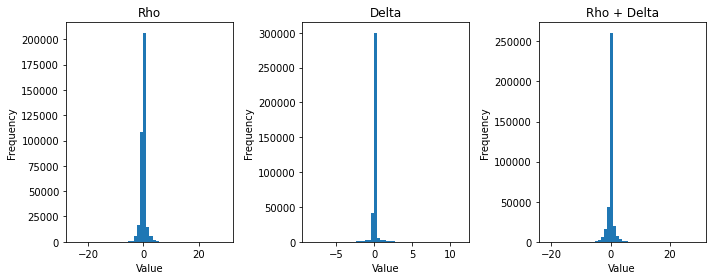

In [5]:
# read in the rho and delta matrices
rho = np.genfromtxt('data/rho_weight.csv', delimiter=',', skip_header=1)
rho = rho[:,1:]
delta = np.genfromtxt('data/delta_weight.csv', delimiter=',', skip_header=1)
delta = delta[:,1:]

# plot histograms side by side
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].hist(rho.flatten(), bins=50, range=(np.amin(rho), np.amax(rho)))
axs[0].set_title('Rho')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(delta.flatten(), bins=50, range=(np.amin(delta), np.amax(delta)))
axs[1].set_title('Delta')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

axs[2].hist((rho + delta).flatten(), bins=50, range=(np.amin(rho + delta), np.amax(rho + delta)))
axs[2].set_title('Rho + Delta')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

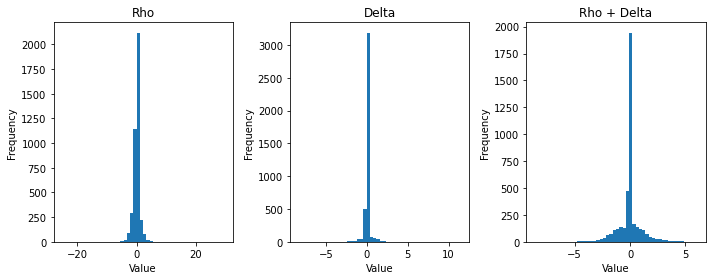

In [6]:
N = 5000 # set the number of cells to select randomly
G = 1000  # set the number of columns to select randomly
T = 4  # set the number of rho and delta topics, respectively

n_topic, n_gene = rho.shape  # get the total number of columns in rho
topics_to_select = np.random.choice(n_topic, size=T, replace=False)
genes_to_select = np.random.choice(n_gene, size=G, replace=False)  # randomly select G columns without replacement
rho_subset = rho[topics_to_select][:, genes_to_select]  # create a new array with selected columns
delta_subset = delta[topics_to_select][:, genes_to_select]  # create a new array with selected columns
# plot histograms side by side
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].hist(rho_subset.flatten(), bins=50, range=(np.amin(rho), np.amax(rho)))
axs[0].set_title('Rho')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(delta_subset.flatten(), bins=50, range=(np.amin(delta), np.amax(delta)))
axs[1].set_title('Delta')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')

axs[2].hist((rho_subset + delta_subset).flatten(), bins=50, range=(np.amin(rho_subset + delta_subset), np.amax(rho_subset + delta_subset)))
axs[2].set_title('Rho + Delta')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [7]:
beta_spliced = np.concatenate((rho_subset, rho_subset + delta_subset), axis=0)
beta_unspliced = np.concatenate((rho_subset, rho_subset), axis=0) 
beta_spliced.shape # (2T, G)

(8, 1000)

In [8]:
N_topic = int(N/(2 * T)) # number of cells per topic
prob_max = 0.9 # probability of the most likely topic
alpha = np.ones([2*T, 2*T]) * (1 - prob_max) / (2 * T - 1) # N x 2T
np.fill_diagonal(alpha, prob_max)
alpha = np.repeat(alpha, N_topic, axis=0)
alpha.shape # (N, 2T)

(5000, 8)

In [9]:
# sample theta from Dirichlet distribution
theta = []
for i in range(alpha.shape[0]):
    sample = np.random.dirichlet(alpha[i])
    theta.append(sample)
    
theta = np.array(theta)

In [10]:
# sample X from multinomial distribution
## assuming all cells have the same sequencing depth
seq_depth = G
X_spliced = []; X_unspliced = []
loading_spliced = np.dot(theta, beta_spliced)
loading_unspliced = np.dot(theta, beta_unspliced)
for i in range(N):
    sample = np.random.multinomial(n= seq_depth, pvals=softmax(loading_spliced[i]), size=1)
    X_spliced.append(sample)
    
X_spliced = np.squeeze(np.array(X_spliced))

for i in range(N):
    sample = np.random.multinomial(n= seq_depth, pvals=softmax(loading_unspliced[i]), size=1)
    X_unspliced.append(sample)
        
X_unspliced = np.squeeze(np.array(X_unspliced))

In [12]:
adata = ad.AnnData(csr_matrix(X_spliced))
adata.layers["counts"] = adata.X.copy()
adata.obsm["unspliced_expression"] = csr_matrix(X_unspliced)

adata.obs_names = [f"Cell_{i:d}" for i in range(adata.n_obs)]
adata.var_names = [f"Gene_{i:d}" for i in range(adata.n_vars)]
adata.obs["topic_true"] = np.repeat([f"topic_{i:d}" for i in range(8)], adata.n_obs/8)

In [14]:
setup_anndata(adata, layer="counts", unspliced_obsm_key = "unspliced_expression")
model = DeltaTopic(adata, n_latent = 8)
model.train(1000)

/home/BCCRC.CA/yzhang/.local/share/r-miniconda/envs/r-reticulate/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:467: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type              | Params
--------------------------------------------

Epoch 40:  72%|███████▏  | 26/36 [00:00<00:00, 87.02it/s, loss=1.21e+04, v_num=1]

/home/BCCRC.CA/yzhang/.local/share/r-miniconda/envs/r-reticulate/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
model.save('models/test')
model.get_parameters(save_dir = "models/test") # spike and slab parameters
topics_np = model.get_latent_representation() # latent topic proportions
pd.DataFrame(topics_np).to_csv("model/test/topics.csv")

Deterministic: True, output_softmax_z: True


/home/BCCRC.CA/yzhang/.local/share/r-miniconda/envs/r-reticulate/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'topic_true' as categorical


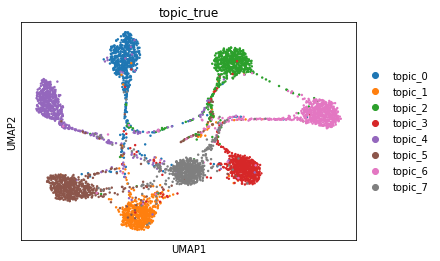

In [69]:
sc.pp.neighbors(adata)
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adatacolor=["topic_true"])

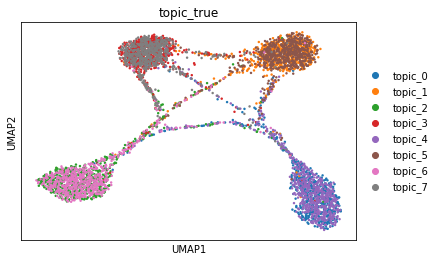

In [70]:
sc.pp.neighbors(adata,use_rep="unspliced_expression")
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color=["topic_true"])

In [71]:
topics_np  = pd.read_csv("models/test/topics.csv")
del topics_np[topics_np.columns[0]]
adata.obsm["topics"] = topics_np.values

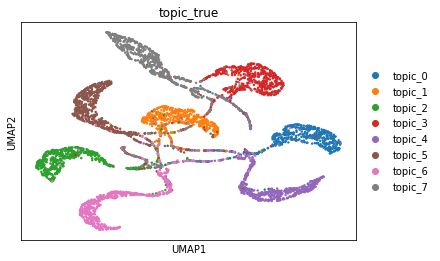

In [72]:
sc.pp.neighbors(adata, use_rep="topics")
sc.tl.umap(adata, random_state=42)
sc.pl.umap(adata, color=["topic_true"])